In [1]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 9
})
from Logistic import LogisticMap
from Lorenz63 import Lorenz63

### Sample trajectories

In [2]:
Logistic = LogisticMap(N=20)
L63 = Lorenz63(dt = 0.1)

Init: Transfer matrix: 100%|██████████| 21/21 [00:00<00:00, 23.30it/s]


In [3]:
X_logistic, _ = Logistic.sample(100, iid=False)
X_L63, _ = L63.sample(100000)

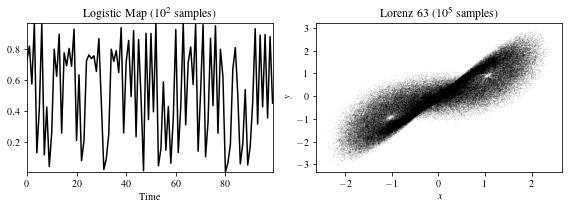

In [4]:
fig, ax= plt.subplots(ncols=2, figsize=(8,3))

ax[0].plot(X_logistic, 'k-')
ax[0].set_title('Logistic Map ($10^2$ samples)')
ax[0].set_xlabel('Time')
ax[0].margins(0)

idx_x = 0
idx_y = 1
ax[1].scatter(X_L63[:, idx_x], X_L63[:, idx_y], c='k', s=0.1, alpha = 0.1)
ax[1].set_title('Lorenz 63 ($10^5$ samples)')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')

plt.tight_layout()
fig.savefig("../../complementary_figures/sample_trajectories.jpg", bbox_inches='tight', dpi=300)


In [4]:
sample_sizes, Lorenz63 = pickle.load(open("../synthetic_systems/data/lorenz63_results.pkl", "rb"))
sample_sizes, Logistic = pickle.load(open("../synthetic_systems/data/logistic_map_results.pkl", "rb"))

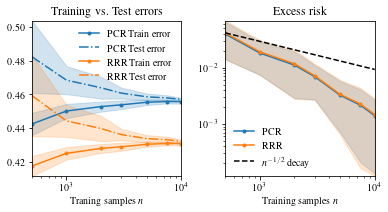

In [15]:
fig_width = 5.5 #Inches
fig_height =fig_width/1.8 #Inches
fig, axes = plt.subplots(ncols=2, figsize=(fig_width, fig_height), sharex='col')
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
titles = ['Training vs. Test errors', 'Excess risk']
data_dicts = [Logistic, Lorenz63]
modes = ['risk', 'excess']

def plot_train_vs_num_samples(ax, data_dict, mode = 'risk'):
    for est_idx, estimator in enumerate(['PCR', 'RRR']):
        train = np.zeros((2, len(sample_sizes)))
        test = np.zeros((2, len(sample_sizes)))
        excess = np.zeros((2, len(sample_sizes)))
        for idx, sample_size in enumerate(sample_sizes):
            tr = data_dict[idx][estimator]['train']
            ts = data_dict[idx][estimator]['test']
            exc = np.abs(tr - ts)
            train[0, idx] =tr.mean()
            train[1, idx] =tr.std()
            test[0, idx] = ts.mean()
            test[1, idx] = ts.std()
            excess[0, idx] = exc.mean()
            excess[1, idx] = exc.std()
        if mode == 'risk':
            ax.set_xticks(sample_sizes)
            ax.set_xscale('log')    
            ax.plot(sample_sizes,train[0], '.-', color = cycle[est_idx], label=f'{estimator} Train error')
            ax.fill_between(sample_sizes,train[0] - train[1],train[0] + train[1], color = cycle[est_idx], alpha=0.2)

            ax.plot(sample_sizes,test[0], '-.', color = cycle[est_idx], label=f'{estimator} Test error')
            ax.fill_between(sample_sizes,test[0] - test[1],test[0] + test[1], color = cycle[est_idx], alpha=0.2)
        elif mode == 'excess':
            ax.set_xticks(sample_sizes)
            ax.set_xscale('log') 
            ax.set_yscale('log')   
            ax.plot(sample_sizes,excess[0], '.-', color = cycle[est_idx], label=f'{estimator}')
            ax.fill_between(sample_sizes,excess[0] - excess[1],excess[0] + excess[1], color = cycle[est_idx], alpha=0.2)
        else:
            pass
        
    if mode == 'risk':
        ax.set_xlabel("Traning samples $n$") 
        ax.legend(frameon=False)
        ax.margins(0)
    elif mode == 'excess':
        sqrt_decay = np.array(sample_sizes)**(-0.5)
        sqrt_decay /= sqrt_decay.max()
        sqrt_decay *= excess[0].max()
        ax.plot(sample_sizes, sqrt_decay, label=r"$n^{-1/2}$ decay", color='k', linestyle='--')
        ax.set_xlabel("Training samples $n$")
        
        ax.legend(frameon=False)
        ax.margins(0)
    else:
        pass     
    return ax

for ax_idx, ax in enumerate(axes):
    ax.set_title(titles[ax_idx])
    plot_train_vs_num_samples(ax, data_dicts[1], mode = modes[ax_idx])
plt.tight_layout()
#fig.savefig("../../complementary_figures/errors_vs_num_samples.jpg", bbox_inches='tight', dpi=300) #For GitHub
#fig.savefig("uniform_bound_lorenz63.pdf", bbox_inches='tight') #For publication